# Cartpole Playground

### Import Packages

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### Create and reset the environment

In [2]:
# Create the environment
env = gym.make("CartPole-v1") #, render_mode="human")
test_env = gym.make("CartPole-v1")
state, info = env.reset()

SEED = 1234

np.random.seed(SEED);
torch.manual_seed(SEED);

# Get the state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### Create the policy network

In [3]:
# Define the policy function (neural network)
class Policy(nn.Module):
    def __init__(self, use_activation = True):
        super(Policy, self).__init__()
        
        # Policy activation and dropout
        self.use_activation = use_activation
        
        # Define paramaeters for layers
        self.num_hidden_layers = 1
        self.dimensions = [state_size, 128, action_size]
        
        # Define layers
        self.layers = nn.ModuleList()
        for i in range(self.num_hidden_layers):
            # Linear layer
            self.layers.append(nn.Linear(self.dimensions[i], self.dimensions[i+1]))
            # Activation layer
            if self.use_activation:
                self.layers.append(nn.ReLU())
        # Output layer
        self.layers.append(nn.Linear(self.dimensions[-2], self.dimensions[-1]))
        
    # Forward pass of the policy
    def forward(self, x):
        
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            
        # Softmax to get probs
        return torch.softmax(x, dim=-1)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.001)
        
policy = Policy()
policy.apply(init_weights)
print(policy)

Policy(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [4]:
torch.tensor([[1,2],[2,3]])[:1,:]

tensor([[1, 2]])

<IPython.core.display.Javascript object>


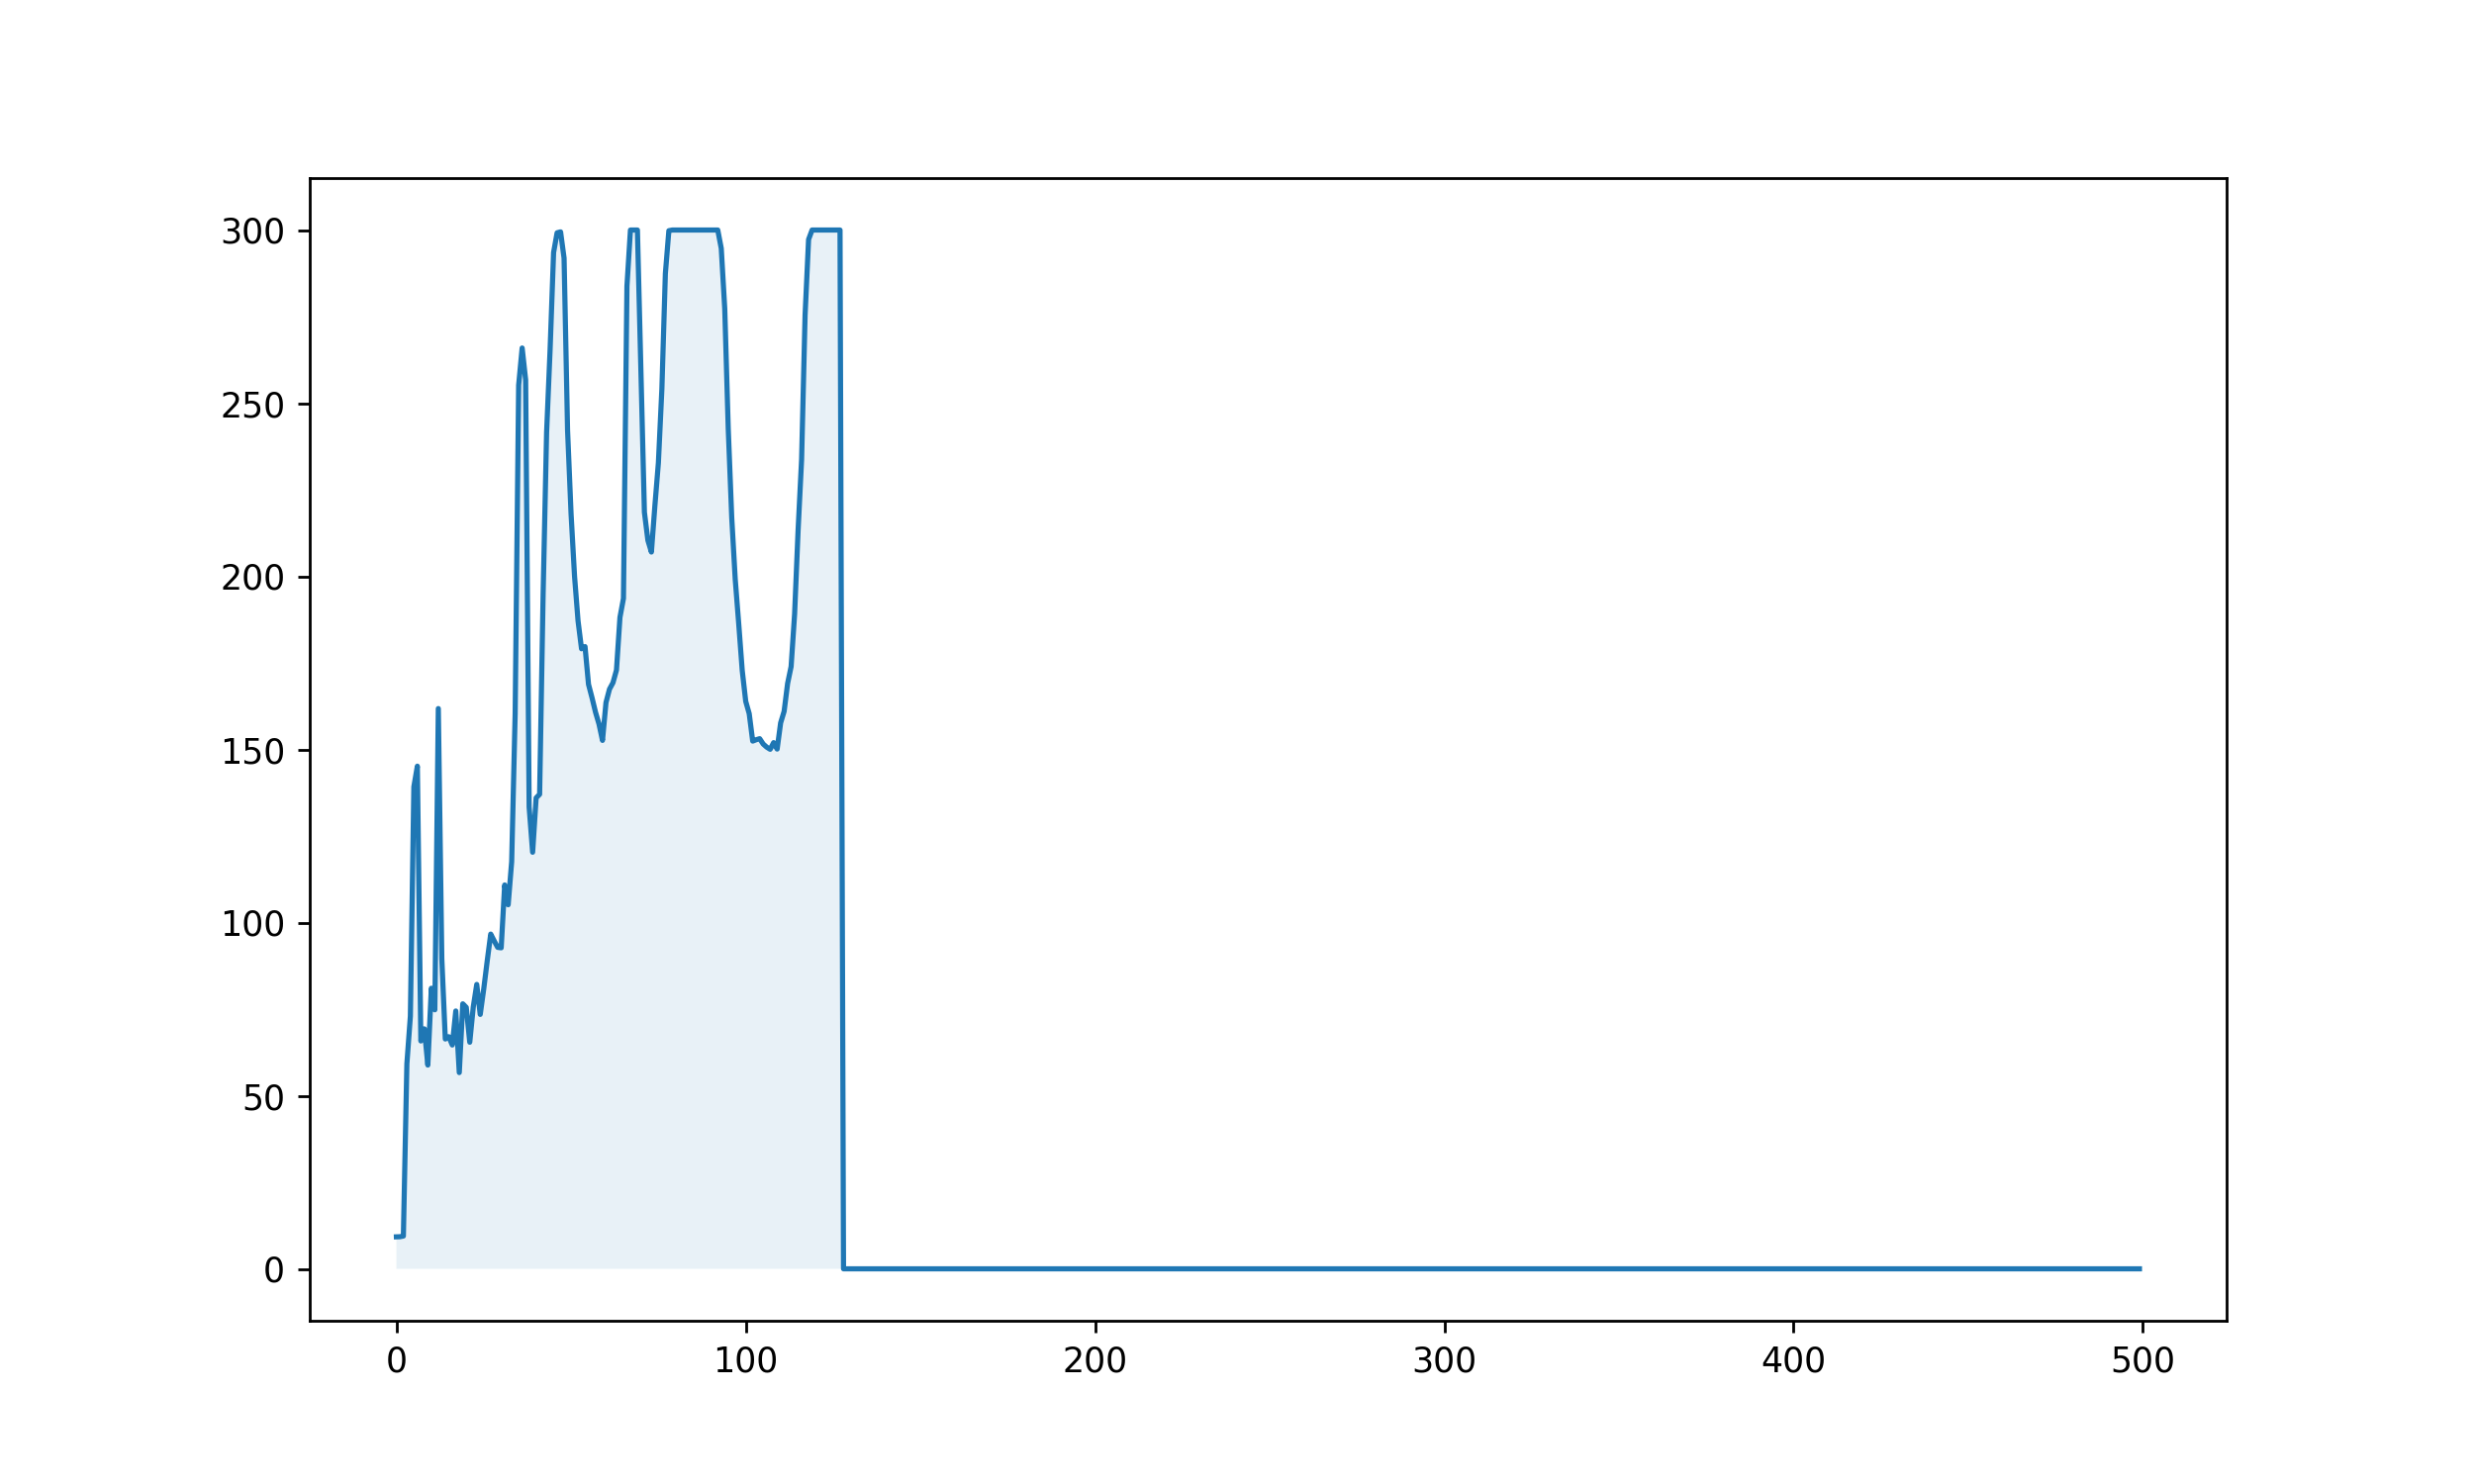

Text(0, 0.5, 'Rewards')

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt

n_runs = 5
max_episodes = 500
discount_factor = 0.99


idxs = range(max_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.set_xlabel('Steps')
ax.set_ylabel('Rewards')

In [6]:


from reinforce import *
from rl_functions import * 
import tqdm


PRINT_EVERY= 20
N_TRIALS = 25
BATCH_SIZE = 5
TEST_BATCH_SIZE = 30
MAX_EPS_LENGTH = 300
REWARD_THRESHOLD = 200

train_rewards = torch.zeros(n_runs, max_episodes)
test_rewards = torch.zeros(n_runs, max_episodes)
losses = torch.zeros(n_runs, max_episodes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for run in range(n_runs):
    
    policy = Policy()
    policy = policy.to(device)
    # policy.apply(init_weights)
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)
    
    for episode in tqdm.tqdm(range(max_episodes), desc=f'Run: {run}'):
        
        loss, train_reward = train(env, policy, optimizer, update_policy_reinforce_static_baseline, False, 
                                   MAX_EPS_LENGTH, discount_factor, BATCH_SIZE, device)
        
        test_reward = evaluate(test_env, policy, MAX_EPS_LENGTH, TEST_BATCH_SIZE, device)
        
        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward
        losses[run][episode] = loss
        
        if episode % PRINT_EVERY == 0:
            mean_train_rewards = torch.mean(train_rewards[run, max(0,episode-N_TRIALS):episode+1])
            mean_test_rewards = torch.mean(test_rewards[run, max(0,episode-N_TRIALS):episode+1])
            mean_losses = torch.mean(losses[run, max(0,episode-N_TRIALS):episode+1])
        
            print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} ',
                  f'| Mean Test Rewards: {mean_test_rewards:5.1f} | Mean Losses: {mean_losses:5.1f} |')
        
#         if mean_test_rewards >= REWARD_THRESHOLD:
        
#             print(f'Reached reward threshold in {episode} episodes')
#             plt.savefig("VPG_128_1HL.png")
#             break
            
            
        ax.clear()
        ax.plot(idxs, test_rewards[:run+1, :].mean(0))
        ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
        
        fig.canvas.draw()

cpu


Run: 0:   0%|▏                                                                         | 1/500 [00:00<01:11,  7.01it/s]

| Episode:   0 | Mean Train Rewards:  17.8  | Mean Test Rewards:   9.2 | Mean Losses: 118.7 |


Run: 0:   4%|███                                                                      | 21/500 [00:06<02:47,  2.86it/s]

| Episode:  20 | Mean Train Rewards:  34.9  | Mean Test Rewards:  72.7 | Mean Losses: 448.2 |


Run: 0:   8%|█████▉                                                                   | 41/500 [00:17<04:56,  1.55it/s]

| Episode:  40 | Mean Train Rewards:  55.4  | Mean Test Rewards: 112.3 | Mean Losses: 971.9 |


Run: 0:  12%|████████▉                                                                | 61/500 [00:32<05:00,  1.46it/s]

| Episode:  60 | Mean Train Rewards:  83.0  | Mean Test Rewards: 206.3 | Mean Losses: 1922.2 |


Run: 0:  16%|███████████▊                                                             | 81/500 [00:50<06:43,  1.04it/s]

| Episode:  80 | Mean Train Rewards:  95.8  | Mean Test Rewards: 224.3 | Mean Losses: 2491.3 |


Run: 0:  20%|██████████████▌                                                         | 101/500 [01:09<04:43,  1.41it/s]

| Episode: 100 | Mean Train Rewards:  95.2  | Mean Test Rewards: 270.3 | Mean Losses: 2532.9 |


Run: 0:  24%|█████████████████▍                                                      | 121/500 [01:23<06:20,  1.00s/it]

| Episode: 120 | Mean Train Rewards:  79.7  | Mean Test Rewards: 193.3 | Mean Losses: 1882.8 |


Run: 0:  26%|██████████████████▍                                                     | 128/500 [01:31<04:27,  1.39it/s]


KeyboardInterrupt: 

In [7]:
torch.save(policy, "VPG_128.pth")

300.0
300.0
300.0
300.0
300.0
300.0
299.93333333333334
300.0
300.0
300.0
300.0
300.0
300.0
299.8666666666667
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
299.93333333333334
300.0
300.0
299.9
300.0
300.0
300.0
300.0
300.0
299.8666666666667
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
